# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2

#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

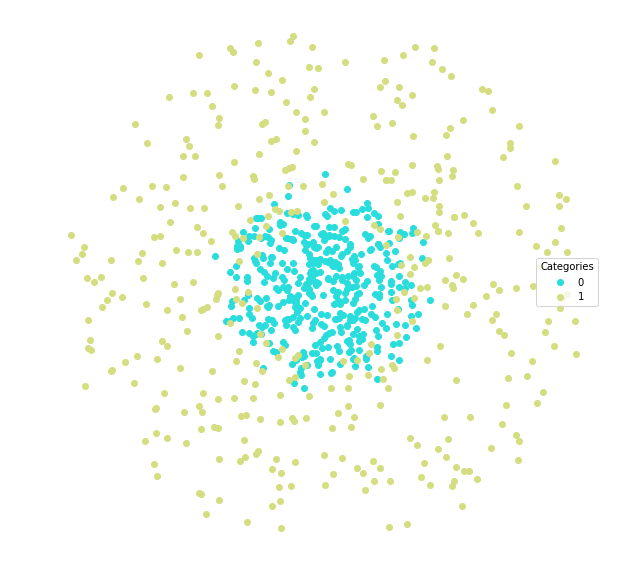

In [3]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [4]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [5]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [6]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.865657,0.771004,0.14,0.798077,0.922222
1,0.865657,0.855095,0.14,0.927083,0.809091


This lets us look at which classes do better:

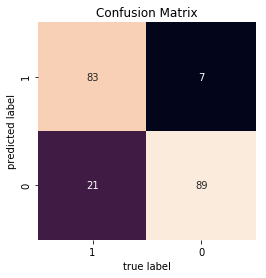

In [7]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

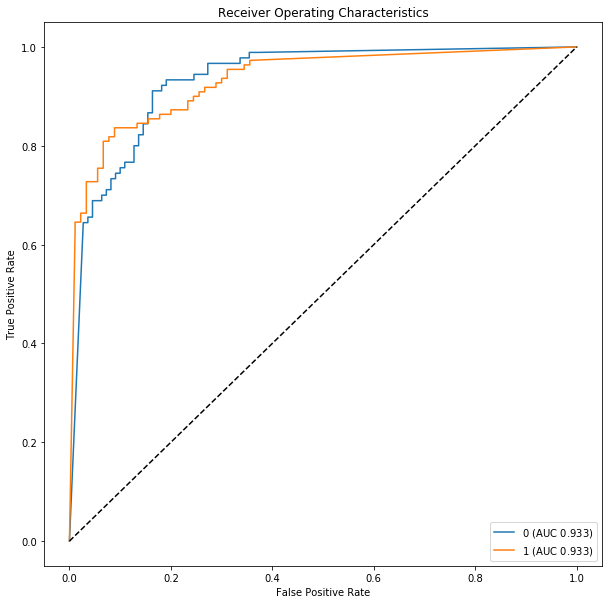

In [8]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

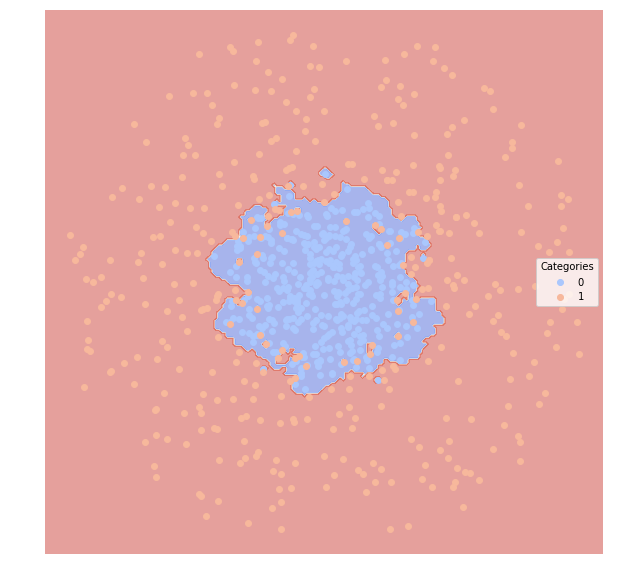

In [9]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [10]:
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Reddit data
Converting to vectors


In [12]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [13]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None)

In [14]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.734736,0.502260,0.178683,0.696970,0.554217
Weeaboo Tales,0.841393,0.525529,0.206897,0.544776,0.935897
Relationships,0.720546,0.511964,0.181818,0.745763,0.505747
Tales From Tech Support,0.841010,0.673259,0.090909,0.850000,0.718310


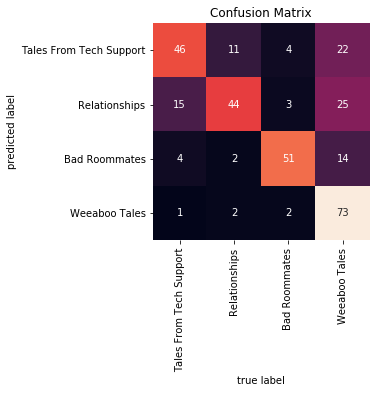

In [15]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

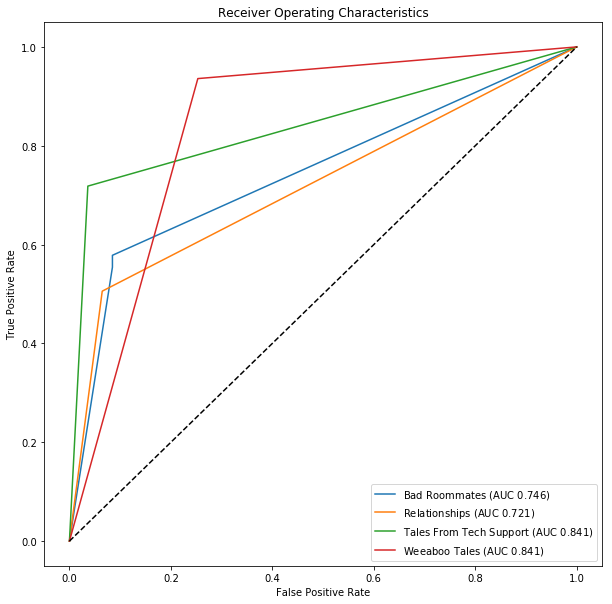

In [16]:
lucem_illud.plotMultiROC(clf, dfTest)

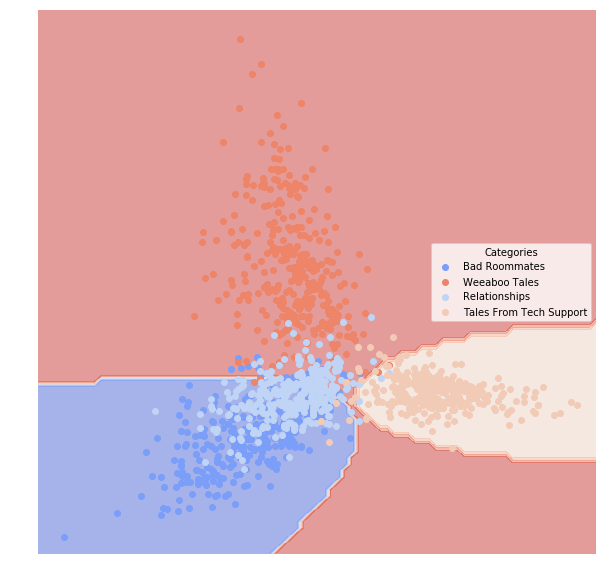

In [17]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [46]:
all_clf_methods = {'Naive Bayes':sklearn.naive_bayes.GaussianNB(),
                   'SVM (Linear)':sklearn.svm.SVC(kernel = 'linear', probability = True),
                   'SVM (Poly)': sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True),
                   'K-Nearest Neighbors': sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
                   'Logistic Regression': sklearn.linear_model.LogisticRegression(),
                   'Decision Tree' : sklearn.tree.DecisionTreeClassifier(),
                   'Random Forest' : sklearn.ensemble.RandomForestClassifier(),
                   'Neural Network' : sklearn.neural_network.MLPClassifier(),
                   'Gradient Boosting' : sklearn.ensemble.GradientBoostingClassifier()}

def evaluate_classifications(dfTrain, dfTest, clf_methods):
    output = []
    for clf_name, clf in clf_methods.items():
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        temp_df = lucem_illud.evaluateClassifier(clf, dfTest)
        temp_df['clf_name'] = clf_name
        output.append(temp_df)
    return pandas.concat(output)

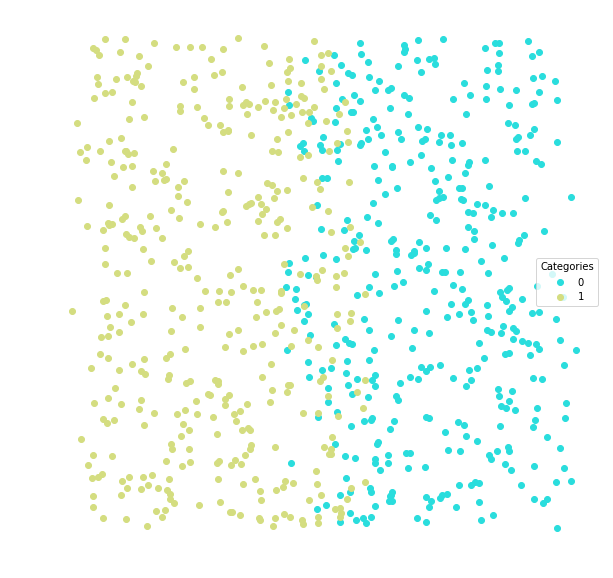

,AUC,Average_Precision,Error_Rate,Precision,Recall,clf_name
Category,,,,,,
0,0.909364,0.866601,0.090,0.888889,0.941176,Naive Bayes
1,0.909364,0.880319,0.090,0.934783,0.877551,Naive Bayes
0,0.904462,0.861920,0.095,0.887850,0.931373,SVM (Linear)
1,0.904462,0.871499,0.095,0.924731,0.877551,SVM (Linear)
0,0.842237,0.769994,0.155,0.775194,0.980392,SVM (Poly)
1,0.842237,0.829248,0.155,0.971831,0.704082,SVM (Poly)
0,0.880152,0.841569,0.120,0.890000,0.872549,K-Nearest Neighbors
1,0.880152,0.827347,0.120,0.870000,0.887755,K-Nearest Neighbors
0,0.904462,0.861920,0.095,0.887850,0.931373,Logistic Regression


In [49]:
#artificial dataset 1 (linearly splitted)
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
lucem_illud.plotter(dfTrain)

#Evaluate all classification results using artificial dataset1
evaluate_classifications(dfTrain, dfTest, all_clf_methods)

#Almost all classification methods had decent performance. Neural network seems to be the best among all.

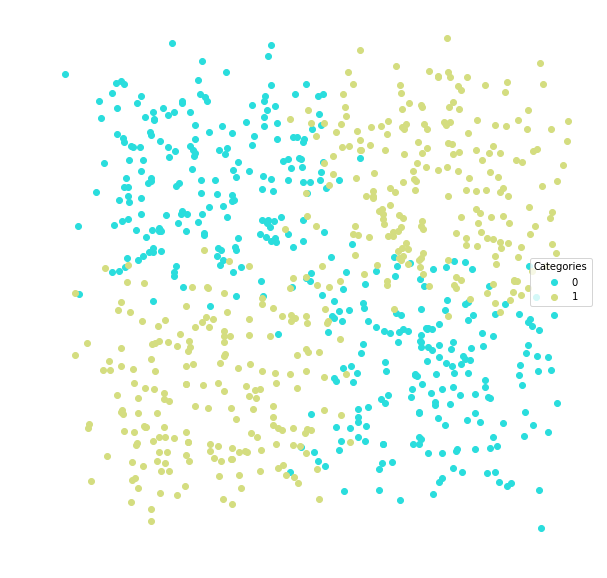

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,AUC,Average_Precision,Error_Rate,Precision,Recall,clf_name
Category,,,,,,
0,0.651230,0.651557,0.355,0.717391,0.594595,Naive Bayes
1,0.651230,0.542921,0.355,0.583333,0.707865,Naive Bayes
0,0.693846,0.697947,0.325,0.828571,0.522523,SVM (Linear)
1,0.693846,0.572446,0.325,0.592308,0.865169,SVM (Linear)
0,0.679117,0.698786,0.350,0.901961,0.414414,SVM (Poly)
1,0.679117,0.557087,0.350,0.563758,0.943820,SVM (Poly)
0,0.862790,0.837523,0.135,0.875000,0.882883,K-Nearest Neighbors
1,0.862790,0.788207,0.135,0.852273,0.842697,K-Nearest Neighbors
0,0.670311,0.669128,0.340,0.752941,0.576577,Logistic Regression


In [50]:
#artificial dataset 2 (X-splitted)
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
lucem_illud.plotter(dfTrain)

#Evaluate all classification results using artificial dataset1
evaluate_classifications(dfTrain, dfTest, all_clf_methods)


#K-Nearest neighbors and Random Forest had the best performance on this dataset, with only an
#error rate of 0.135, followed by Neural Network and Gradient Boosting (0.14).

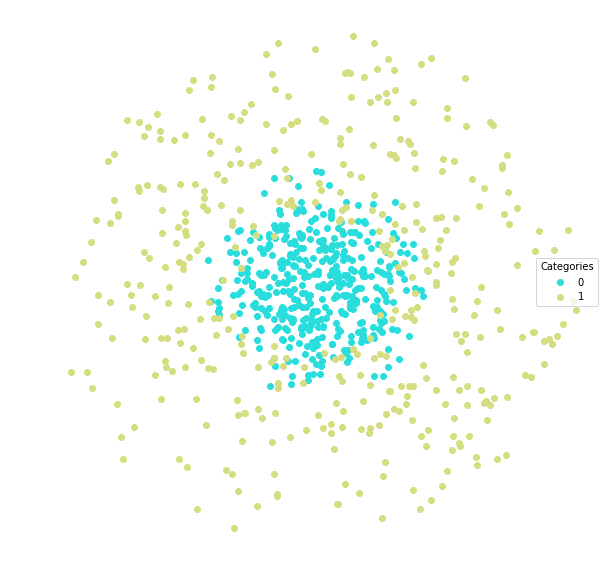

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,AUC,Average_Precision,Error_Rate,Precision,Recall,clf_name
Category,,,,,,
0,0.860462,0.762736,0.145,0.794118,0.910112,Naive Bayes
1,0.860462,0.849622,0.145,0.918367,0.810811,Naive Bayes
0,0.664440,0.544874,0.370,0.547170,0.977528,SVM (Linear)
1,0.664440,0.694212,0.370,0.951220,0.351351,SVM (Linear)
0,0.500000,0.445000,0.555,0.445000,1.000000,SVM (Poly)
1,0.500000,0.555000,0.555,0.000000,0.000000,SVM (Poly)
0,0.852667,0.774183,0.145,0.840909,0.831461,K-Nearest Neighbors
1,0.852667,0.826837,0.145,0.866071,0.873874,K-Nearest Neighbors
0,0.655532,0.540375,0.370,0.552448,0.887640,Logistic Regression


In [51]:
#artificial dataset 2 (targetSplit)
noise = .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
lucem_illud.plotter(dfTrain)

#Evaluate all classification results using artificial dataset1
evaluate_classifications(dfTrain, dfTest, all_clf_methods)


#Gradient boosting had the best performance on this dataset, with the lowest
#error rate of 0.135 and higherst AUC. SVM and logistic regression do not seem to work well on this dataset.

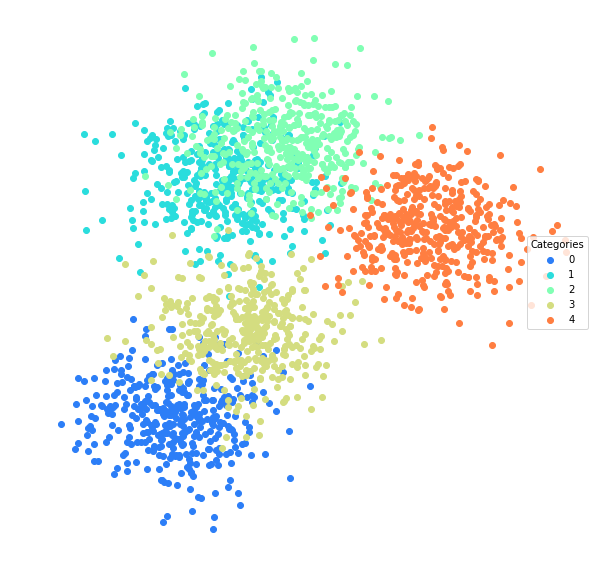

,AUC,Average_Precision,Error_Rate,Precision,Recall,clf_name
Category,,,,,,
0,0.957925,0.882878,0.030,0.927928,0.936364,Naive Bayes
1,0.897995,0.727859,0.066,0.830000,0.838384,Naive Bayes
2,0.904292,0.742727,0.062,0.840000,0.848485,Naive Bayes
3,0.934724,0.846106,0.040,0.923810,0.889908,Naive Bayes
4,0.977132,0.923958,0.014,0.952381,0.963855,Naive Bayes
0,0.953380,0.875835,0.032,0.927273,0.927273,SVM (Linear)
1,0.900552,0.721968,0.068,0.815534,0.848485,SVM (Linear)
2,0.889141,0.719224,0.068,0.835052,0.818182,SVM (Linear)
3,0.933445,0.838350,0.042,0.915094,0.889908,SVM (Linear)


In [54]:
#artificial dataset 2 (X-splitted)
noise = .8
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
lucem_illud.plotter(dfTrain)

#Evaluate all classification results using artificial dataset1
evaluate_classifications(dfTrain, dfTest, all_clf_methods)


#Gradient boosting had the best performance on this dataset, with only an
#error rate of 0.135. SVM and logistic regression do not seem to work on this dataset.

## Exercise 1 Memo

10 artificial datasets were generated (1 random, 2 linearly-splitted (noise = 0.2 and 0.5), 2 X-splitted (noise = 0.2 and 0.5), 2 target-splitted (noise = 0.2 and 0.5)), and 3 multi-blobs (noise = 0.2, noise = 0.5, noise = 0.8). All methods were tested using each dataset, and some of the results are shown above.

Almost all classification seemed to perform well on linearly-splitted datasets and multi-blob datasets. Naive Bayes, SVMs and logistic regression performed relatively poorly on X-splitted datasets. SVMs and logistic regression performed relatively poorly on target-splitted (circle-shaped) datasets.

Gradient boosting, random forest, and neural network appeared to be reliable in all cases. I will further test these classification results using my own dataset.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [67]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [68]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [69]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [70]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [71]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [72]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [73]:
TFVects.shape

(1368, 11344)

We can save this in the dataframe to make things easier

In [74]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [76]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [77]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

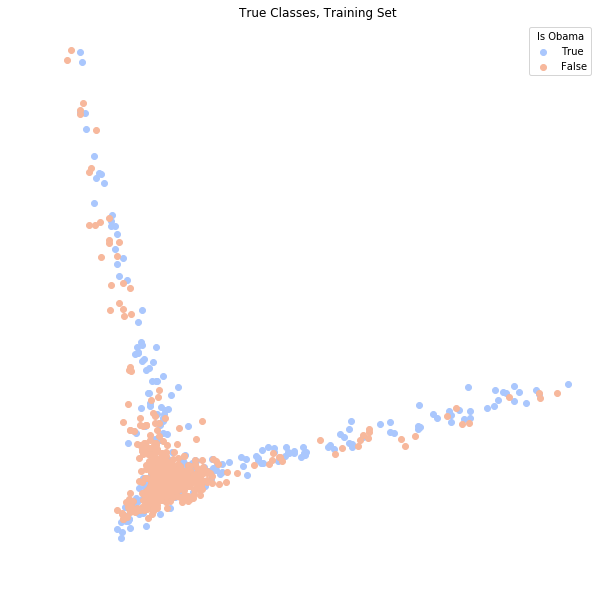

In [78]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

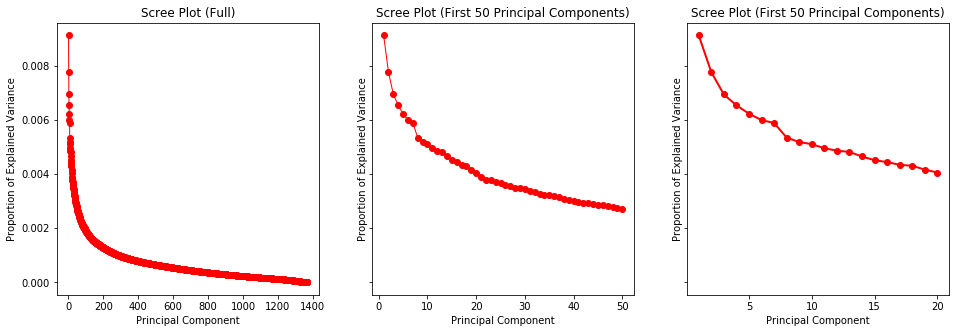

In [79]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [80]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [81]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [82]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.685672514619883

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [83]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6539589442815249

Slightly poorer. How about using more dimensions (40)?

In [84]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7302631578947368
Testing:
0.7008797653958945


Or still more (100)?

In [85]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.810672514619883
Testing:
0.750733137829912


Or even more (200)!

In [86]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8633040935672515
Testing:
0.8064516129032258


This is becoming ridiculous (400)!

In [87]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9013157894736842
Testing:
0.8299120234604106


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [88]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8201754385964912


Train the model using training data, and then test it on the testing data.

In [89]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7888563049853372


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [90]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [91]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9437134502923976
Testing:
0.8768328445747801


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [92]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [93]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8263888888888888

Recall:

In [94]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.875

F1-measure:

In [95]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.8499999999999999

Let's take a look at how well our posterior distribution looks relative to the truth.

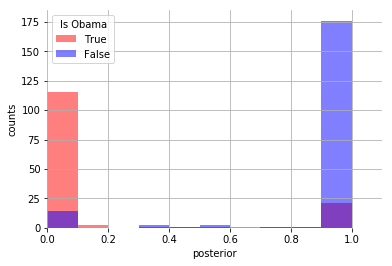

In [96]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [97]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Clinton,Clinton_log_prob,Obama,Obama_log_prob
0,amy,-1.874451,island,-2.284123
1,dick,-1.874451,welcomed,-2.284123
2,monday,-1.897708,awarded,-2.308816
3,brundage,-1.970911,urban,-2.347037
4,chicago,-2.091864,urging,-2.347037
5,reform,-2.181476,ground,-2.360109
6,temporary,-2.181476,read,-2.400383
7,va,-2.197225,welcome,-2.414176
8,cases,-2.262822,construction,-2.428162
9,don,-2.262822,fy,-2.428162


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [4]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [5]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [6]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [7]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [8]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [9]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [10]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [11]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8995937318630296


In [12]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
627,soc.religion.christian,soc.religion.christian
105,talk.religion.misc,soc.religion.christian
1330,sci.space,sci.space
1576,comp.graphics,comp.graphics
1578,comp.graphics,comp.graphics
1496,sci.space,sci.space
1698,comp.graphics,comp.graphics
1668,comp.graphics,comp.graphics
1414,sci.space,sci.space
980,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [13]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7906976744186046


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

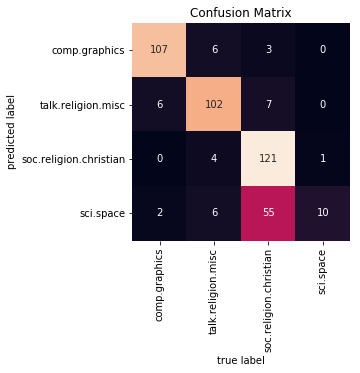

In [14]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [15]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.9089868667586746
0.7906976744186046
0.8296241387118719


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [16]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
soc.religion.christian,0.873251,0.636351,0.162791,0.650538,0.960317
comp.graphics,0.948468,0.879176,0.039535,0.930435,0.922414
talk.religion.misc,0.567093,0.271045,0.148837,0.909091,0.136986
sci.space,0.918081,0.796924,0.067442,0.864407,0.886957


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

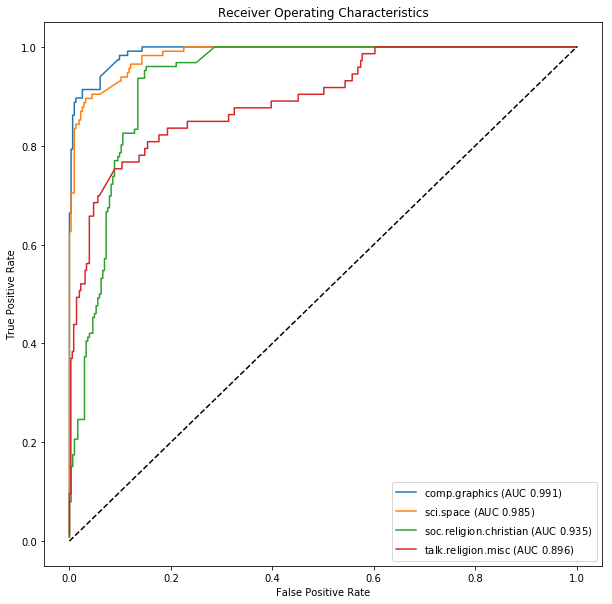

In [17]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

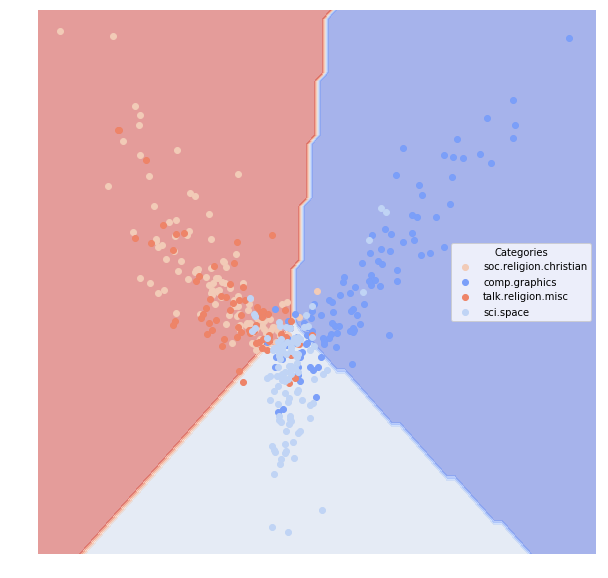

In [18]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [19]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [20]:
predict_category('rockets are cool', MultinomialNB_ng, TFVectorizer_ng)

'sci.space'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [2]:
#Import data
Int0901DF = pandas.read_csv('../data/6_CSV_6_0901CSV-1.csv')
Int0902DF = pandas.read_csv('../data/6_CSV_6_0902CSV-1.csv')
Int09DF = pandas.concat([Int0901DF,Int0902DF])
Int09DF[:2]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN
1,9,1,1,二、本院徐委員榛蔚，針對今（105）年2月6日南台強震，台南地區因盲斷層影響，產生「震源效應...,901,NaN


In [3]:
#Extract name of legislators
def extract_name(string):
    name_str = string.split('、')[1].replace('本院','').replace('委員','')
    return name_str

Int09DF['name'] = Int09DF['item'].str.split("，").apply(lambda x: x[0])
Int09DF['name'] = Int09DF['name'].apply(extract_name)

#clean interpellation content
def clean_int(content):
    cleaned_content = '，'.join(content.split('，')[1:])
    return cleaned_content

Int09DF['clean item'] = Int09DF['item'].apply(clean_int)

In [4]:
#cut words

import jieba.analyse
import jieba

jieba.set_dictionary('../data/dict.txt.big.txt')

jieba.load_userdict('../data/AdditionalWords.txt')

Int09DF['segmented_words'] = Int09DF['clean item'].apply(jieba.lcut)
Int09DF['segmented_words'].head()

Building prefix dict from /home/lingdai/content-analysis-2018/data/dict.txt.big.txt ...
Dumping model to file cache /tmp/jieba.u2ed7f306195aa74fd365f7c489494496.cache
Loading model cost 1.821 seconds.
Prefix dict has been built succesfully.


0    [鑑於, 我國, 建築, 技術, 及, 橋樑, 規範, 於, 921, 地震, 之後, ，,...
1    [針對, 今, （, 105, ）, 年, 2, 月, 6, 日, 南台, 強震, ，, 台...
2    [針對, 台, 9, 線, 蘇花公路, 山區, 路段, 改善, 計畫, （, 以下, 簡稱,...
3    [有鑑於, 每逢, 農曆年, 假鐵, 公路, 運輸量, 暴增, ，, 復, 因今, （, 1...
4    [就, 國立中興大學, 徵, 「, 零元, 講師, 」, 乙事, ，, 特, 向, 行政院,...
Name: segmented_words, dtype: object

In [144]:
#Remove Stopwords

TChineseStopWords = pandas.read_csv('../data/TraditionalChineseStopwords.txt',
                                    header = None, delimiter="\t",
                                    quoting=3, error_bad_lines=False).loc[:,0].tolist()

Add_Stopwords = ['質詢','建請','行政院','鑒於','鑑於','針對','為','相關','要求',
                 '我國','單位','政府', '發生','檢討','今','以下','近日','有鑑於',
                 '台灣','目前','造成','事件','問題','無法','一事','影響','「','」',
                 '提出','本席','儘速','進行']

TChineseStopWords = TChineseStopWords + Add_Stopwords

def Remove_TChinese_Stopwords(words, list_of_stopwords):
    output = [word for word in words if word not in list_of_stopwords]
    return output

Int09DF['normalized_words'] = Int09DF['segmented_words'].apply(Remove_TChinese_Stopwords,
                                                               list_of_stopwords = TChineseStopWords)
Int09DF['joined_text'] = Int09DF['normalized_words'].apply(" ".join)

In [145]:
#Match party information

Legi9Data = pandas.read_csv('../data/9_TXT_9_TXT.txt',
                              lineterminator='\n')

def match_party(name):
    matched = Legi9Data[Legi9Data['name']==name]['party'].values
    if len(matched) > 0:
        return matched[0]
    else:
        return None
    
Int09DF['party']= Int09DF['name'].apply(lambda x: match_party(x))
Int09DF['party'].unique()

array(['中國國民黨', '民主進步黨', None, '無黨籍', '親民黨'], dtype=object)

In [307]:
#Subset of Data that have hand-classified categories

#1:,‘社会福利及卫生环境’,2:,‘财政’,,3:,‘内政’,
#4,:‘外交与国防’,,5:‘教育及文化’,,6:‘交通’,,7:‘司法’,,8:‘经济’

cat = [3,1,5,6,5,8,1,3,1,5,
       5,1,1,5,3,3,8,5,7,7,
       5,1,7,6,1,5,7,8,7,1,
       8,5,6,5,4,8,4,3,1,6,
       3,5,4,6,7,7,4,6,1,6,
       1,3,5,1,3,5,3,1,6,6,
       5,5,5,3,3,8,3,5,3,4,
       5,1,6,4,3,2,1,6,2,8,
       8,1,6,8,6,4,8,8,1,3,
       7,1,8,3,1,1,1,1,3,7]

#1: 内政，财政，司法, 交通
#2: 社会福利和环境卫生, 教育及文化
#3: 国防与外交
#4: 经济

SubInt09DF = Int09DF[:100].copy()
SubInt09DF['category'] = cat

In [147]:
#Store Vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(SubInt09DF['joined_text'])
SubInt09DF['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#Store PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(SubInt09DF['vect'], axis=0))
SubInt09DF['pca'] = [r for r in reduced_data]

SubInt09DF[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,normalized_words,joined_text,party,category,vect,pca
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN,徐榛蔚,鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗震標準，然於民國88...,"[鑑於, 我國, 建築, 技術, 及, 橋樑, 規範, 於, 921, 地震, 之後, ，,...","[建築, 技術, 橋樑, 規範, 921, 地震, 之後, 重新制定, 耐震, 係數, 提高...",建築 技術 橋樑 規範 921 地震 之後 重新制定 耐震 係數 提高 建物 抗震 標準 民...,中國國民黨,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.018352187830797367, -0.06838646162609216, ..."


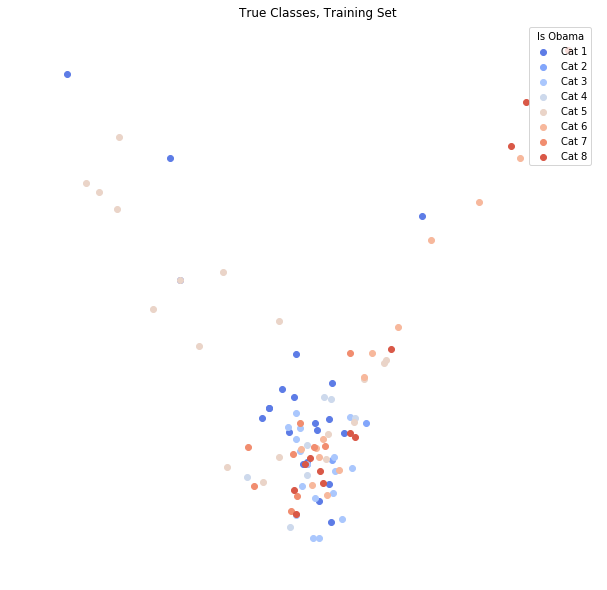

In [148]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 8)

Category_Index = {1: '内政，财政，司法, 交通',
                  2: '社会福利和环境卫生, 教育及文化',
                  3: '国防与外交',
                  4: '经济'}


a = np.stack(SubInt09DF[SubInt09DF['category']==1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "Cat 1")

a = np.stack(SubInt09DF[SubInt09DF['category']==2]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "Cat 2")

a = np.stack(SubInt09DF[SubInt09DF['category']==3]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[2], label = "Cat 3")

a = np.stack(SubInt09DF[SubInt09DF['category']==4]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[3], label = "Cat 4")

a = np.stack(SubInt09DF[SubInt09DF['category']==5]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[4], label = "Cat 5")

a = np.stack(SubInt09DF[SubInt09DF['category']==6]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[5], label = "Cat 6")

a = np.stack(SubInt09DF[SubInt09DF['category']==7]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[6], label = "Cat 7")

a = np.stack(SubInt09DF[SubInt09DF['category']==8]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[7], label = "Cat 8")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

In [191]:
def sim_category(cat_number):
    if cat_number in [1,2,3,4,5]:
        return 1
    else:
        return 2

SubInt09DF['category'] = cat
SubInt09DF['sim_category']=SubInt09DF['category'].apply(sim_category)
SubInt09DF[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,normalized_words,joined_text,party,category,vect,pca,sim_category
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN,徐榛蔚,鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗震標準，然於民國88...,"[鑑於, 我國, 建築, 技術, 及, 橋樑, 規範, 於, 921, 地震, 之後, ，,...","[建築, 技術, 橋樑, 規範, 921, 地震, 之後, 重新制定, 耐震, 係數, 提高...",建築 技術 橋樑 規範 921 地震 之後 重新制定 耐震 係數 提高 建物 抗震 標準 民...,中國國民黨,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.018352187830797367, -0.06838646162609216, ...",1


In [192]:
# Split Data Intro Train and Test

holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(SubInt09DF, holdBackFraction=holdBackFraction)

In [193]:
#Store Vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['joined_text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#Store PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

train_data_df[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,normalized_words,joined_text,party,category,vect,pca,sim_category
31,9,1,2,二十七、本院黃委員昭順，針對近來媒體披露，多數公私立中小學午〈晚〉餐質量不符社會期待，引發諸...,901,NaN,黃昭順,針對近來媒體披露，多數公私立中小學午〈晚〉餐質量不符社會期待，引發諸多聯想，家長迭有抱怨與質...,"[針對, 近來, 媒體, 披露, ，, 多數, 公私, 立, 中小學, 午, 〈, 晚, 〉...","[媒體, 披露, 多數, 公私, 中小學, 午, 晚, 餐, 質量, 不符, 社會, 期待,...",媒體 披露 多數 公私 中小學 午 晚 餐 質量 不符 社會 期待 引發 諸多 聯想 家長 ...,中國國民黨,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.12908666669611044, 0.17453105072148495, 0....",1


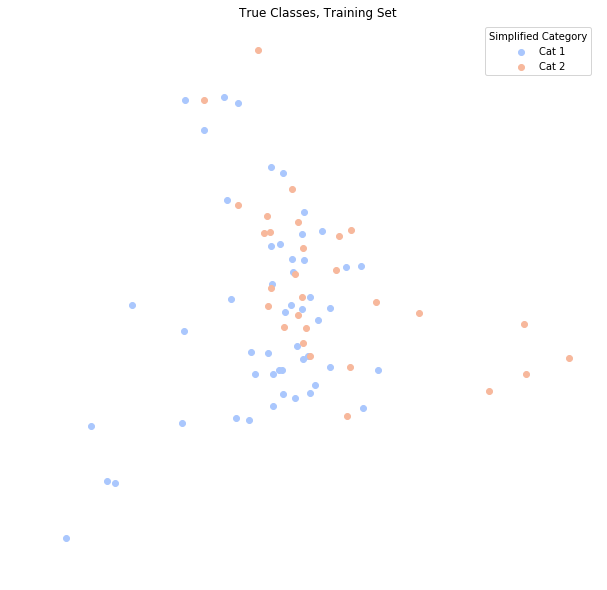

In [194]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)


a = np.stack(train_data_df[train_data_df['sim_category']==1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "Cat 1")

a = np.stack(train_data_df[train_data_df['sim_category']==2]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "Cat 2")

ax.legend(loc = 'upper right', title = 'Simplified Category')
plt.title('True Classes, Training Set')
plt.show()

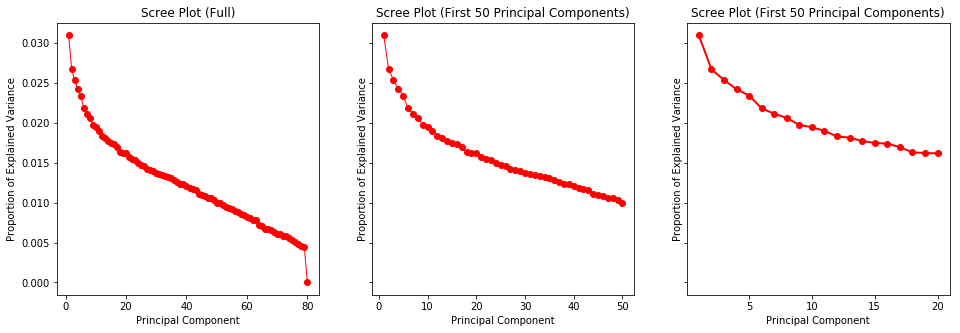

In [195]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [196]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['joined_text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

In [197]:
#Logistic, PCA: 20
train_data_df['pca_reduced_20'] = train_data_df['pca'].apply(lambda x: x[:20])
test_data_df['pca_reduced_20'] = test_data_df['pca'].apply(lambda x: x[:20])

#Without penalty term
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_20'], axis=0), train_data_df['sim_category'])

#Training Score
print("Logistic Regression, 20 Components\n")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_20'], axis=0), train_data_df['sim_category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_20'], axis=0), test_data_df['sim_category']))

Logistic Regression, 20 Components

Training:
0.725
Testing:
0.8


In [198]:
#Logistic, PCA: 40
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['sim_category'])

#Training Score
print("Logistic Regression, 40 Components\n")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['sim_category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['sim_category']))

Logistic Regression, 40 Components

Training:
0.7875
Testing:
0.8


In [199]:
#Logistic, PCA: 40
train_data_df['pca_reduced_60'] = train_data_df['pca'].apply(lambda x: x[:60])
test_data_df['pca_reduced_60'] = test_data_df['pca'].apply(lambda x: x[:60])

logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_60'], axis=0), train_data_df['sim_category'])

#Training Score
print("Logistic Regression, 60 Components\n")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_60'], axis=0), train_data_df['sim_category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_60'], axis=0), test_data_df['sim_category']))

Logistic Regression, 60 Components

Training:
0.8
Testing:
0.8


In [200]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['sim_category'])

print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['sim_category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['sim_category']))

Training:
0.925
Testing:
0.8


In [201]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [202]:
print(sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['sim_category']))
print(sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['sim_category']))
print(sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['sim_category']))

0.9333333333333333
0.8235294117647058
0.8749999999999999


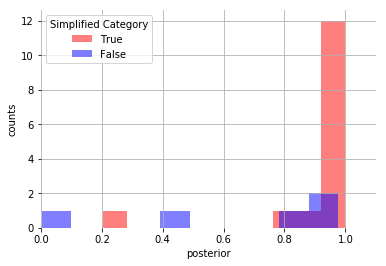

In [203]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['sim_category']==1]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['sim_category']==2]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Simplified Category")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [204]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Cat1' : [],
    'Cat1_log_prob' : [],
    'Cat2' : [],
    'Cat2_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Cat1'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Cat1_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Cat2'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Cat2_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Cat1,Cat1_log_prob,Cat2,Cat2_log_prob
0,政策,-1.667707,發展,-1.236763
1,105,-1.773067,交通部,-1.354546
2,安全,-1.773067,高雄,-1.488077
3,民眾,-1.773067,國人,-1.642228
4,積極,-1.773067,積極,-1.642228
5,保障,-1.890850,觀光,-1.642228
6,健康,-1.890850,勞工,-1.824549
7,學校,-1.890850,因應,-1.824549
8,學生,-1.890850,國民,-1.824549
9,未來,-1.890850,安全,-1.824549


In [205]:
#Multinomial Distribution

MultinomialNB = sklearn.naive_bayes.MultinomialNB()
MultinomialNB.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [206]:
train_data_df['mnnb_predict'] = MultinomialNB.predict(np.stack(train_data_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Training score:
0.9875


In [207]:
train_data_df[['category', 'mnnb_predict']][:10]

,category,mnnb_predict
31,5,5
59,6,6
4,5,5
63,3,3
1,1,1
52,5,5
62,5,5
27,8,8
35,8,8
87,8,8


In [208]:
test_data_df['mnnb_predict'] = MultinomialNB.predict(np.stack(test_data_df['vect'], axis=0))
#Test
print("Testing score:")
print(MultinomialNB.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.5


0.8083333333333333
0.5
0.5901960784313725


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


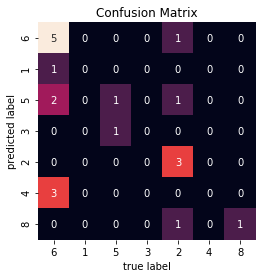

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


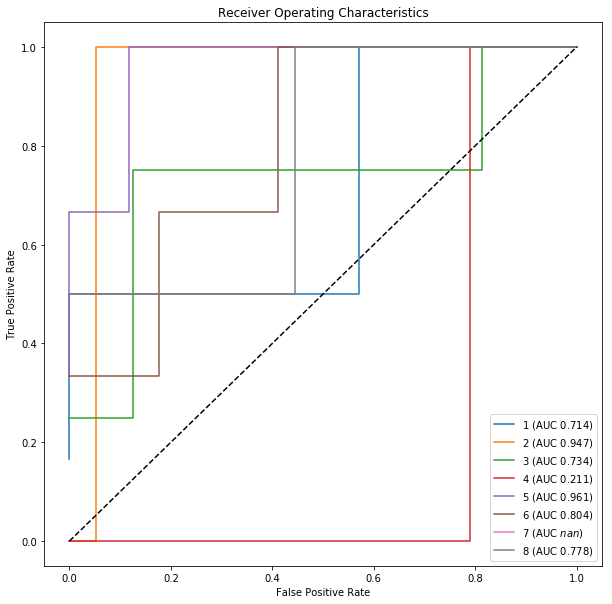

In [209]:
print(sklearn.metrics.precision_score(test_data_df['mnnb_predict'], test_data_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_data_df['mnnb_predict'], test_data_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_data_df['mnnb_predict'], test_data_df['category'], average = 'weighted')) #F-1 measure

lucem_illud.metrics.evaluateClassifier(MultinomialNB, test_data_df)

lucem_illud.plotConfusionMatrix(MultinomialNB, test_data_df)

lucem_illud.plotMultiROC(MultinomialNB, test_data_df)

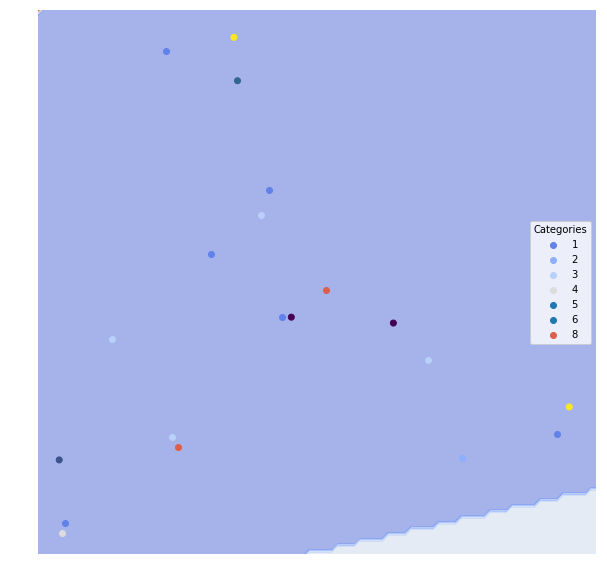

In [210]:
lucem_illud.plotregions(MultinomialNB, test_data_df)

## Exercise 2 Memo:

The corpus that I used is documents of interpellations at Legislative Yuan in Taiwan.

For exercise 2, The sample I used originally consisted of 100 hand-classified documents with 8 different classes. These 8 classes were used because they are in alignment with the structure of Legislative Yuan in Taiwan as well as the categorization of Taiwanese laws. However, the size of the sample seemed far to small for the training purpose of machine learning classification methods.

Overall, because of the insufficient sample size and the large number of categories, the classification result wasn't very optimal, with only an f1 score of 0.6. Therefore, I tried to aggregate these 8 classes into two broader categories, based on there relative positions on the PCA map. Specifically, the original class 1-5 were classified into simplified class 1, and the rest were classified as simplified class 2. I then redid some analysis using these two simplified classes, and observed significantly improved results. Using the same classification method, the f1 score for simplified classes were around 0.87.

In the following exercises, I continued to test the methods first using the original 8 classes. And at the end of this notebook, I redid all the analysis using the simplified classes.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

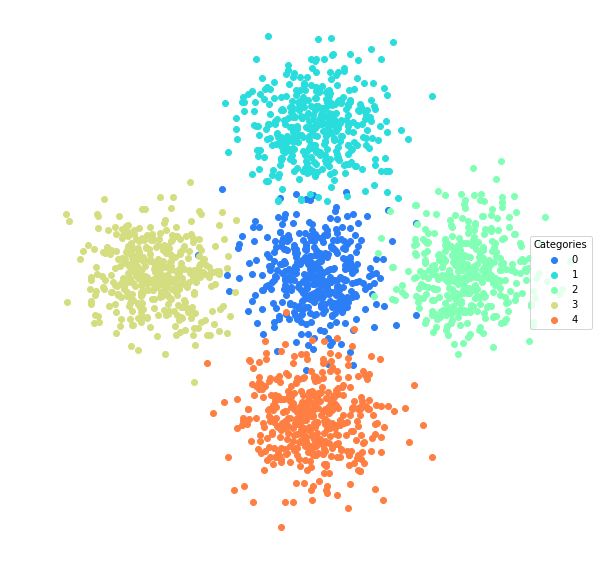

In [216]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [217]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

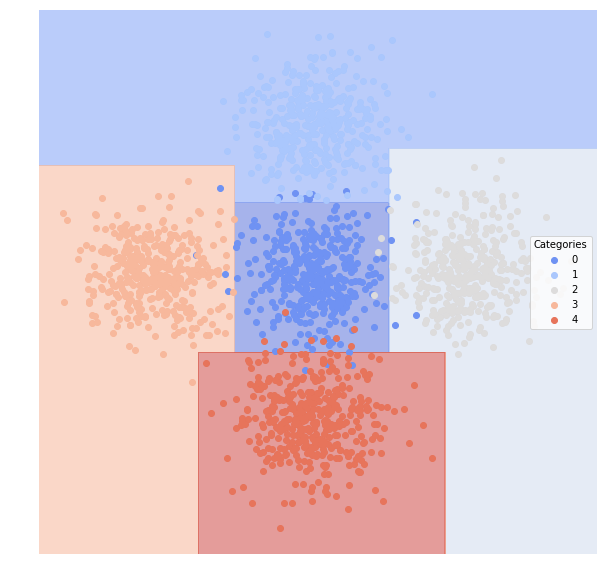

In [218]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [219]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.959081,0.897688,0.024,0.949495,0.930693
1,0.986250,0.954891,0.010,0.970297,0.980000
2,0.993750,0.982100,0.004,0.990000,0.990000
3,0.985565,0.949297,0.012,0.963303,0.981308
4,0.987905,0.971511,0.006,0.989011,0.978261


Lets look at accuracy:

In [220]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.972

What happens if we trim the tree?

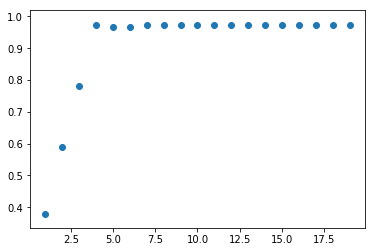

In [221]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [222]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [223]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

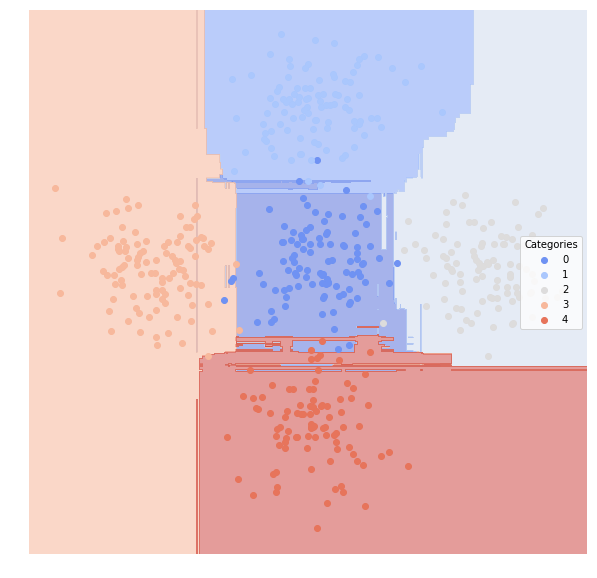

In [224]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [225]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.957828,0.888851,0.026,0.940000,0.930693
1,0.986250,0.954891,0.010,0.970297,0.980000
2,0.993750,0.982100,0.004,0.990000,0.990000
3,0.991510,0.965388,0.008,0.972477,0.990654
4,0.989130,0.982261,0.004,1.000000,0.978261


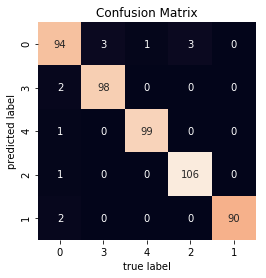

In [226]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [228]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [249]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
1,0.511905,0.305128,0.55,0.307692,0.666667
2,0.500000,0.050000,0.05,0.000000,0.000000
3,0.500000,0.200000,0.20,0.000000,0.000000
4,0.473684,0.050000,0.10,0.000000,0.000000
5,0.637255,0.266667,0.15,0.500000,0.333333
6,0.500000,0.150000,0.15,0.000000,0.000000
8,0.666667,0.175000,0.20,0.250000,0.500000


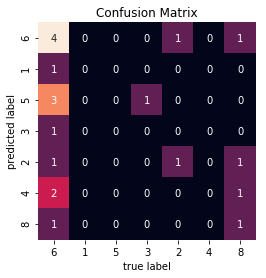

In [248]:
lucem_illud.plotConfusionMatrix(clf_tree, test_data_df)

In [251]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.3

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


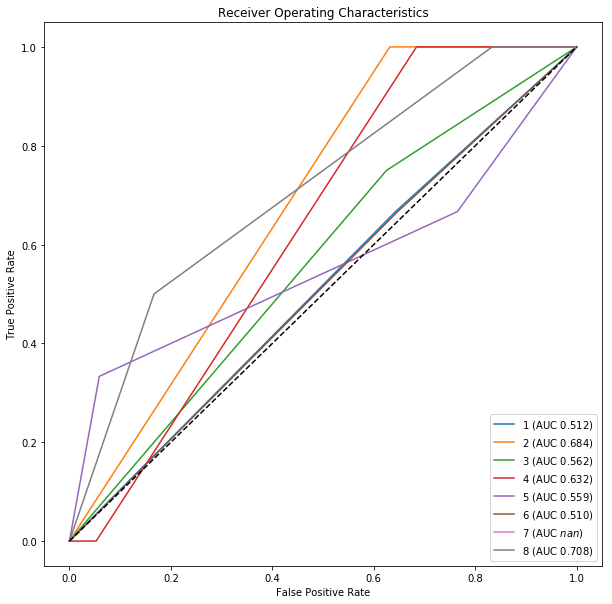

In [294]:
lucem_illud.plotMultiROC(clf_tree, test_data_df)

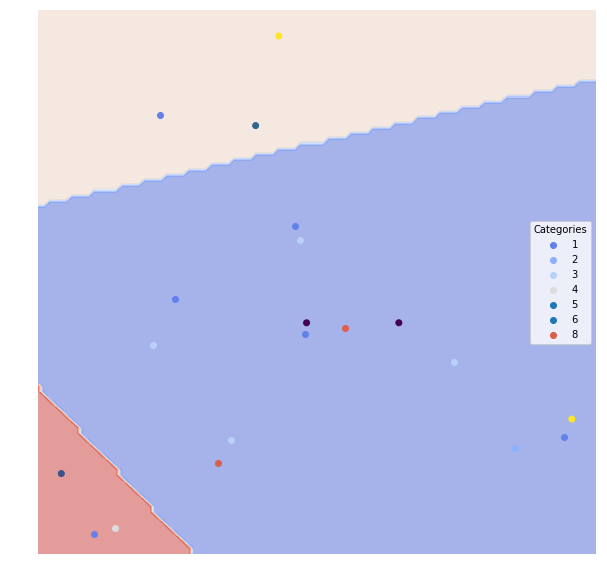

In [295]:
lucem_illud.plotregions(clf_tree, test_data_df)

In [242]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [253]:
lucem_illud.evaluateClassifier(bag, test_data_df)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
1,0.619048,0.366667,0.40,0.400000,0.666667
2,0.500000,0.050000,0.05,0.000000,0.000000
3,0.562500,0.233333,0.25,0.333333,0.250000
4,0.500000,0.050000,0.05,0.000000,0.000000
5,0.803922,0.494444,0.10,0.666667,0.666667
6,0.666667,0.433333,0.10,1.000000,0.333333
8,0.722222,0.300000,0.10,0.500000,0.500000


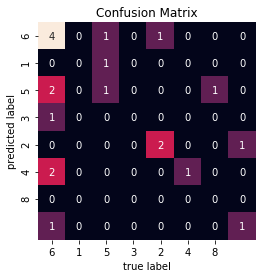

In [255]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

In [257]:
sklearn.metrics.accuracy_score(test_data_df['category'],bag.predict(np.stack(test_data_df['vect'], axis = 0)))

0.45

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


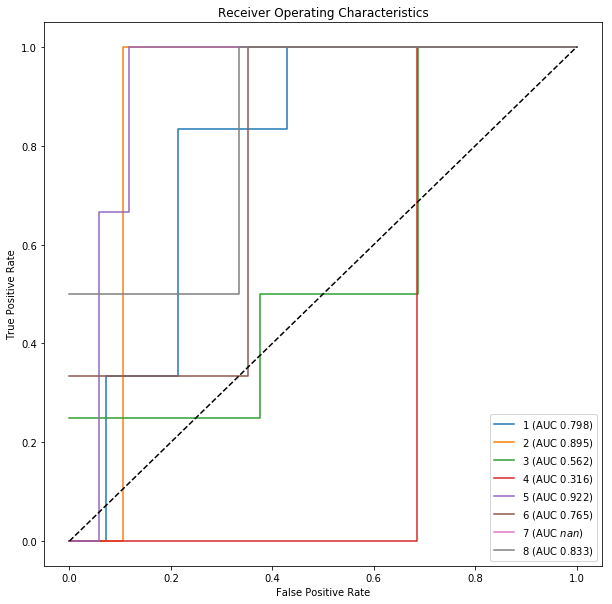

In [296]:
lucem_illud.plotMultiROC(bag, test_data_df)

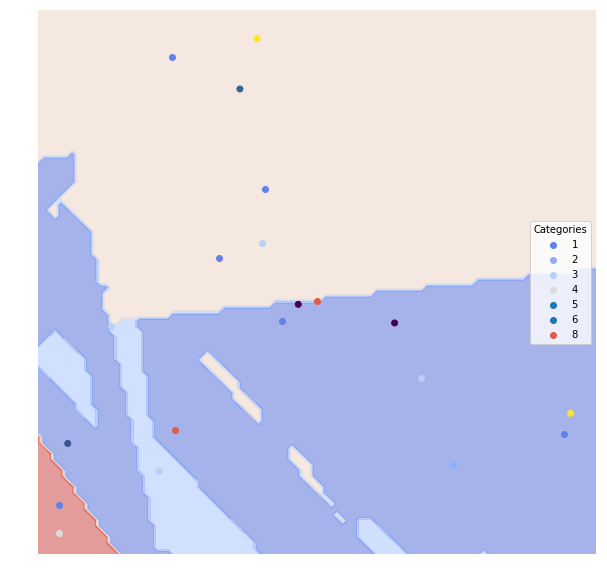

In [254]:
lucem_illud.plotregions(bag, test_data_df)

## Exercise 3 Memo

The simple decision tree classifier actually yielded the worst classification results among all methods tested. The test accuracy for decision tree is only 0.3. According to the AUC plot, the prediction accuracy for most classes are not significantly different from pure guessing.

Compared to simple decision tree model, bagging definitely showed some improvement. The test accuracy for bagging is 0.45. However, similar to the case of logistic regression, bagging failed heavily on predicting class 4 ("国防与外交", National Defense and Diplomacy). The method worked best on predicting class 5 ('教育和文化', Education and Culture), with an AUC of 0.8.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [291]:
n_neighbors = 10
weights="distance"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

In [292]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
1,0.761905,0.544444,0.20,0.666667,0.666667
2,0.500000,0.050000,0.05,0.000000,0.000000
3,0.812500,0.500000,0.15,0.600000,0.750000
4,0.500000,0.050000,0.05,0.000000,0.000000
5,0.911765,0.500000,0.15,0.500000,1.000000
6,0.637255,0.266667,0.15,0.500000,0.333333
8,0.750000,0.550000,0.05,1.000000,0.500000


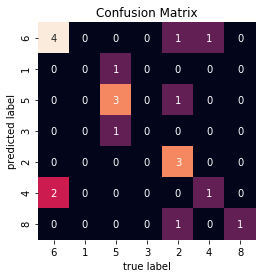

In [293]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

In [299]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_knearest.predict(np.stack(test_data_df['vect'], axis = 0)))

0.6

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


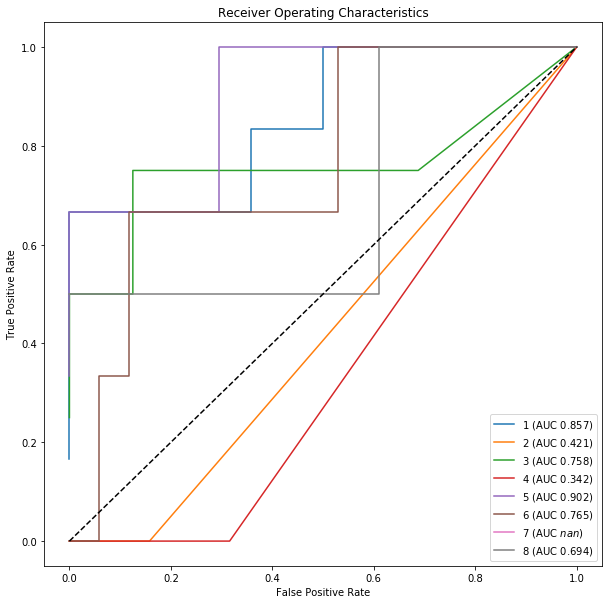

In [300]:
lucem_illud.plotMultiROC(clf_knearest, test_data_df)

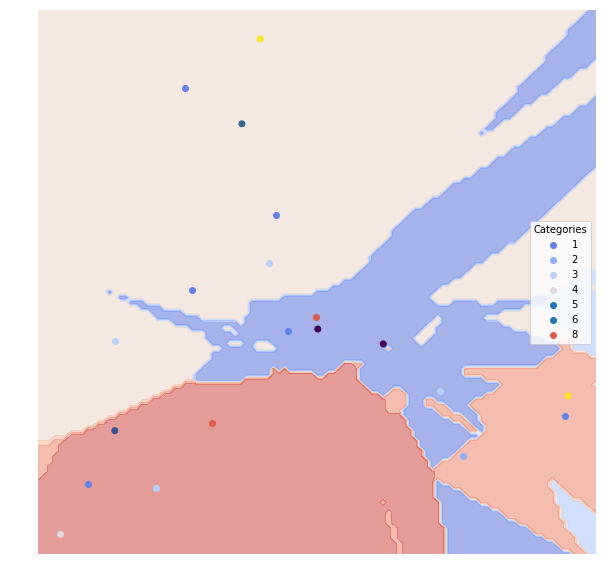

In [298]:
lucem_illud.plotregions(clf_knearest, test_data_df)

## Exercise 4 Memo

For this exercise, I first tested different parameters of KNN, and ultimately chose to proceed using k = 10 and distance as the weight, which had the best accuracy among all combinations of parameters tested.

Possibly due to my selection of parameters, KNN yielded the best prediction results among all classifiers that I tested. The test accuracy for KNN is 0.6, correctly predicting 12 cases out of 20 test observastions.

Somewhat similar to previous methods, KNN worked extremely well on predicting class 5 (AUC = 0.902) and worked poorly on predicting class 4 (AUC = 0.342) and class 2 (AUC = 0.421).

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [301]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [302]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
1,0.642857,0.400000,0.30,0.500000,0.500000
2,0.500000,0.050000,0.05,0.000000,0.000000
3,0.750000,0.600000,0.10,1.000000,0.500000
4,0.500000,0.050000,0.05,0.000000,0.000000
5,0.911765,0.500000,0.15,0.500000,1.000000
6,0.607843,0.211111,0.20,0.333333,0.333333
8,0.750000,0.550000,0.05,1.000000,0.500000


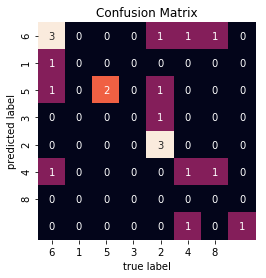

In [303]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

In [304]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_nn.predict(np.stack(test_data_df['vect'], axis = 0)))

0.5

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


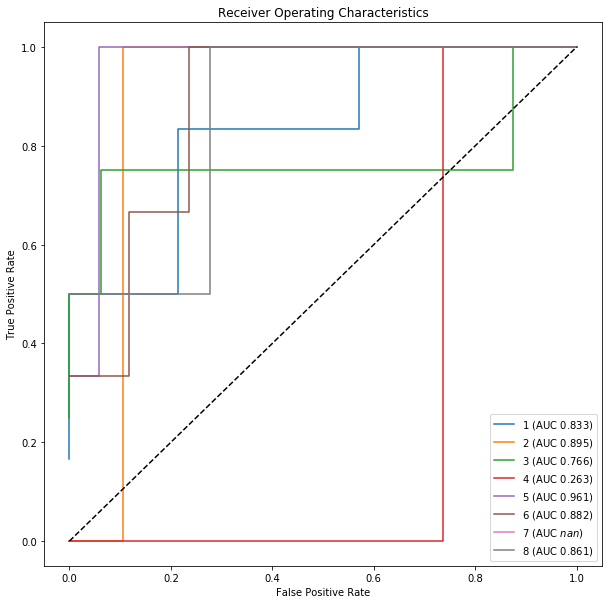

In [305]:
lucem_illud.plotMultiROC(clf_nn, test_data_df)

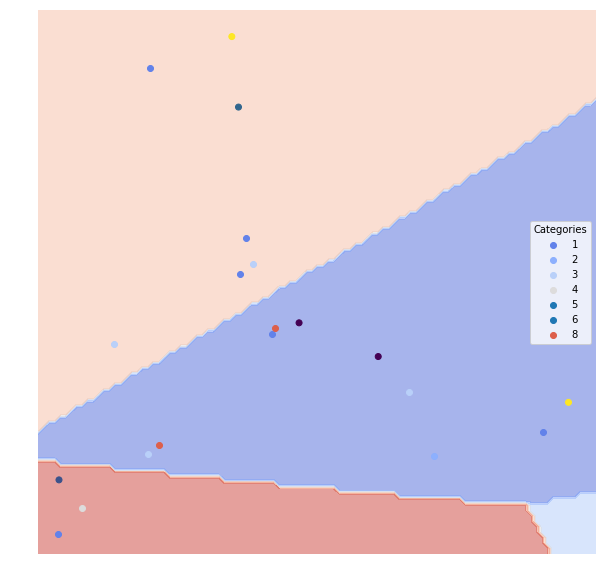

In [306]:
lucem_illud.plotregions(clf_nn, test_data_df)

## Exercise 5 Memo

The last classifier I tested for 8 classes was neural nets. Possibly due to the limited sample size, the performance of neural nets was not as good as I expected. The test accuracy for neural nets was 0.5. Which means that although it outperformed naive bayes, simple decision tree and bagging, it did not achieve the same accuracy level of KNN.

A much larger sample is probably needed in order to take full advantage of neural nets.

## Test Classification Methods with Fewer Classes?

In [308]:
#Subset of Data that have hand-classified categories

#1:,‘社会福利及卫生环境’,2:,‘财政’,,3:,‘内政’,
#4,:‘外交与国防’,,5:‘教育及文化’,,6:‘交通’,,7:‘司法’,,8:‘经济’

cat = [3,1,5,6,5,8,1,3,1,5,
       5,1,1,5,3,3,8,5,7,7,
       5,1,7,6,1,5,7,8,7,1,
       8,5,6,5,4,8,4,3,1,6,
       3,5,4,6,7,7,4,6,1,6,
       1,3,5,1,3,5,3,1,6,6,
       5,5,5,3,3,8,3,5,3,4,
       5,1,6,4,3,2,1,6,2,8,
       8,1,6,8,6,4,8,8,1,3,
       7,1,8,3,1,1,1,1,3,7]

#1: 内政，财政，司法, 交通
#2: 社会福利和环境卫生, 教育及文化
#3: 国防与外交
#4: 经济

SubInt09DF = Int09DF[:100].copy()
SubInt09DF['category'] = cat

In [309]:
def sim_category(cat_number):
    if cat_number in [1,2,3,4,5]:
        return 1
    else:
        return 2

SubInt09DF['category'] = cat
SubInt09DF['category']=SubInt09DF['category'].apply(sim_category)
SubInt09DF[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,normalized_words,joined_text,party,category
0,9,1,1,一、本院徐委員榛蔚，鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗...,901,NaN,徐榛蔚,鑑於我國建築技術及橋樑規範於921地震之後，重新制定耐震係數，提高建物抗震標準，然於民國88...,"[鑑於, 我國, 建築, 技術, 及, 橋樑, 規範, 於, 921, 地震, 之後, ，,...","[建築, 技術, 橋樑, 規範, 921, 地震, 之後, 重新制定, 耐震, 係數, 提高...",建築 技術 橋樑 規範 921 地震 之後 重新制定 耐震 係數 提高 建物 抗震 標準 民...,中國國民黨,1


In [310]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(SubInt09DF, holdBackFraction=holdBackFraction)

In [311]:
#Store Vectors
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['joined_text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#Store PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

train_data_df[:1]

,term,sessionPeriod,sessionTimes,item,selectTerm,Unnamed: 5,name,clean item,segmented_words,normalized_words,joined_text,party,category,vect,pca
66,9,1,3,二十、本院黃委員昭順，要求政府全面檢測山坡地住宅及週邊工業區，以確保民眾生命財產和建物結構安...,901,NaN,黃昭順,要求政府全面檢測山坡地住宅及週邊工業區，以確保民眾生命財產和建物結構安全，避免導致類似早期林...,"[要求, 政府, 全面, 檢測, 山坡地, 住宅, 及, 週邊, 工業區, ，, 以, 確保...","[全面, 檢測, 山坡地, 住宅, 週邊, 工業區, 確保, 民眾, 生命財產, 建物, 結...",全面 檢測 山坡地 住宅 週邊 工業區 確保 民眾 生命財產 建物 結構 安全 避免 導致 ...,中國國民黨,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05606794882033701, -0.16260529864324152, -..."


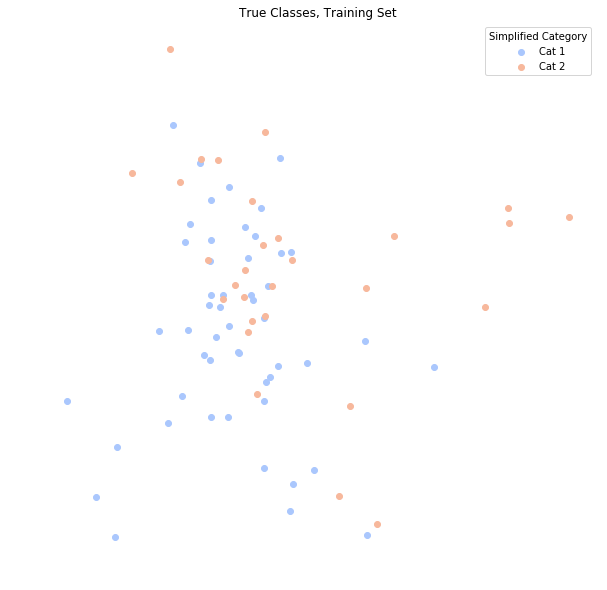

In [312]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)


a = np.stack(train_data_df[train_data_df['category']==1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "Cat 1")

a = np.stack(train_data_df[train_data_df['category']==2]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "Cat 2")

ax.legend(loc = 'upper right', title = 'Simplified Category')
plt.title('True Classes, Training Set')
plt.show()

In [314]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['joined_text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

## Naive Bayes

In [338]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [339]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [340]:
print(sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category']))
print(sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category']))
print(sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category']))

0.8666666666666667
0.8125
0.8387096774193549


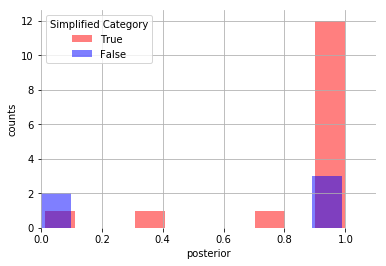

In [318]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category']==1]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category']==2]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Simplified Category")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [319]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Cat1' : [],
    'Cat1_log_prob' : [],
    'Cat2' : [],
    'Cat2_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Cat1'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Cat1_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Cat2'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Cat2_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Cat1,Cat1_log_prob,Cat2,Cat2_log_prob
0,安全,-1.572397,發展,-1.131402
1,民眾,-1.572397,交通部,-1.354546
2,健康,-1.773067,觀光,-1.354546
3,政策,-1.773067,民眾,-1.488077
4,避免,-1.773067,高雄,-1.488077
5,105,-1.890850,安全,-1.642228
6,積極,-1.890850,規劃,-1.642228
7,維護,-1.890850,交通,-1.824549
8,主管機關,-2.024382,市場,-1.824549
9,保障,-2.024382,權益,-1.824549



Test Accuracy:
0.75

Recall Score:
0.75

F1 Score:
0.7598566308243728


               AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
1         0.633333           0.804167        0.25     0.8125  0.866667
2         0.633333           0.350000        0.25     0.5000  0.400000


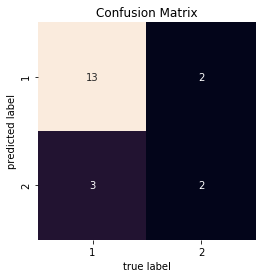

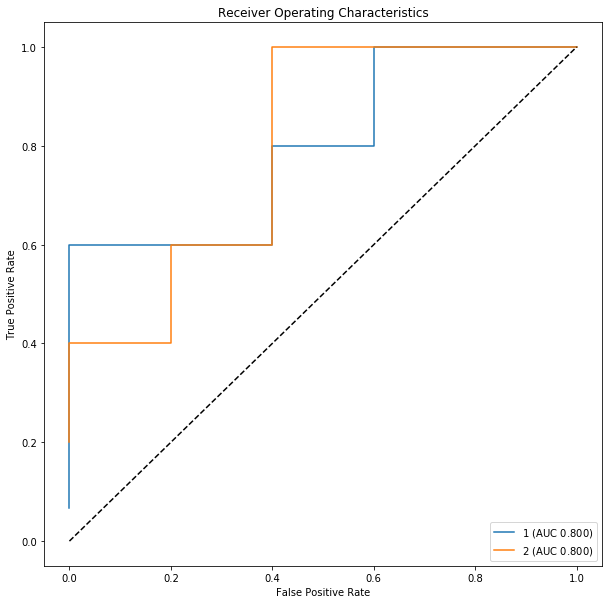

In [354]:
model = naiveBayes
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)

## Multinomial Distribution

In [355]:
MultinomialNB = sklearn.naive_bayes.MultinomialNB()
MultinomialNB.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [356]:
train_data_df['mnnb_predict'] = MultinomialNB.predict(np.stack(train_data_df['vect'], axis=0))
test_data_df['mnnb_predict'] = MultinomialNB.predict(np.stack(test_data_df['vect'], axis=0))


Test Accuracy:
0.8

Recall Score:
0.8

F1 Score:
0.81875


               AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
1         0.666667           0.818627         0.2   0.823529  0.933333
2         0.666667           0.416667         0.2   0.666667  0.400000


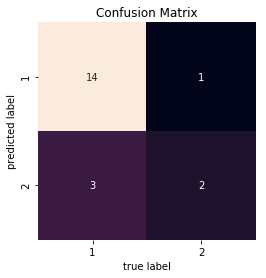

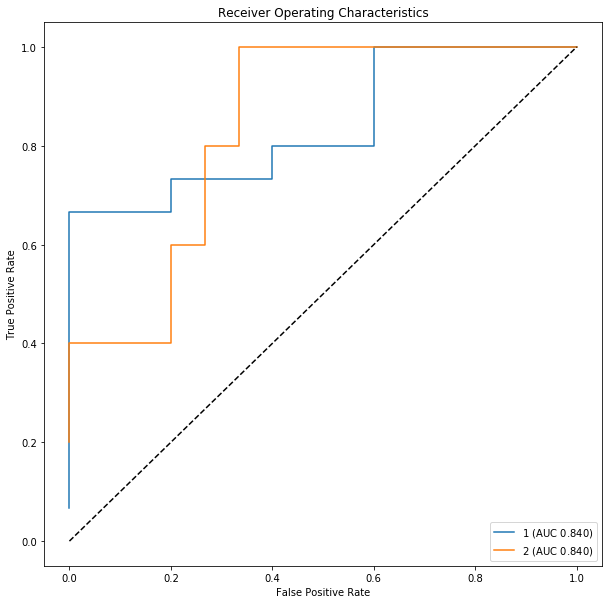

In [357]:
model = MultinomialNB
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)

## Decision Tree

In [358]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')


Test Accuracy:
0.8

Recall Score:
0.8

F1 Score:
0.81875


               AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
1         0.666667           0.818627         0.2   0.823529  0.933333
2         0.666667           0.416667         0.2   0.666667  0.400000


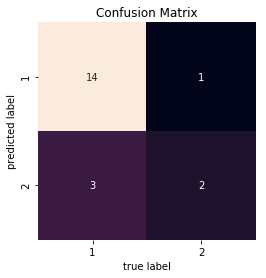

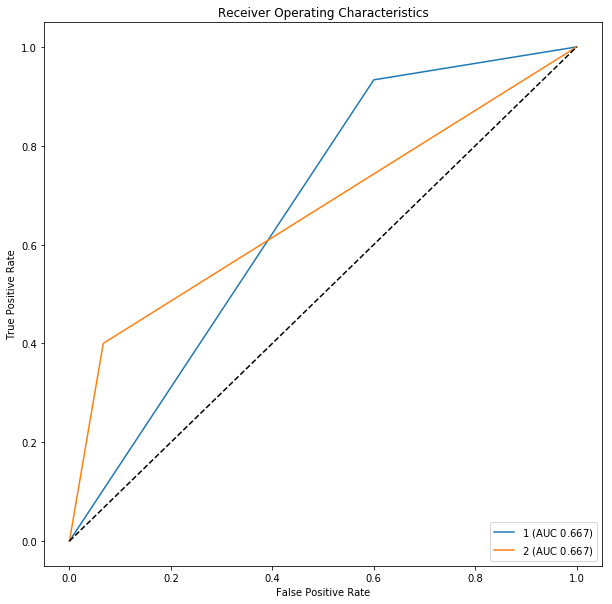

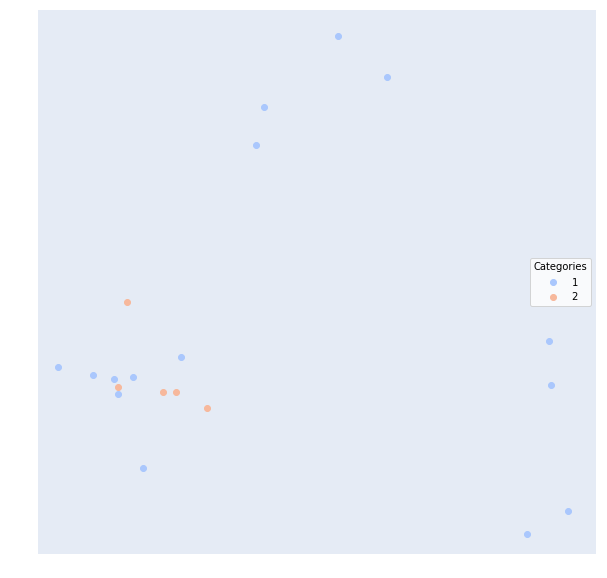

In [359]:
model = clf_tree
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

## Bagging

In [360]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)


Test Accuracy:
0.75

Recall Score:
0.75

F1 Score:
0.7598566308243728


               AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
1         0.633333           0.804167        0.25     0.8125  0.866667
2         0.633333           0.350000        0.25     0.5000  0.400000


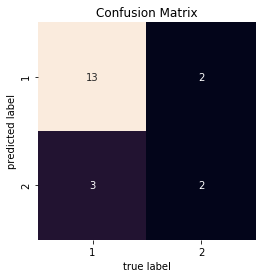

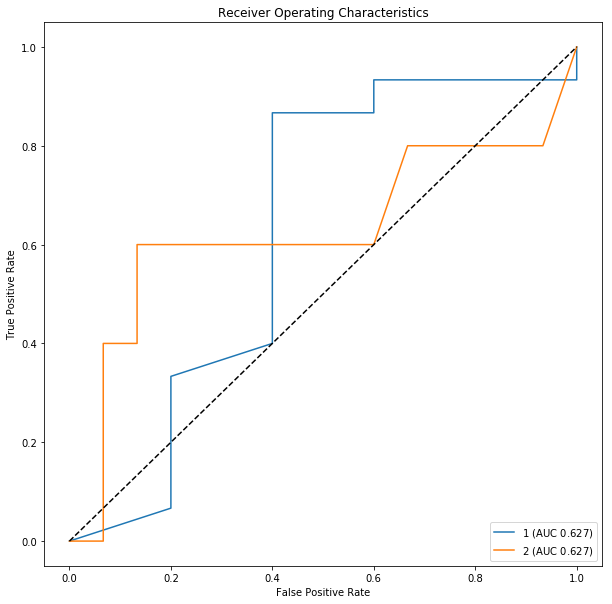

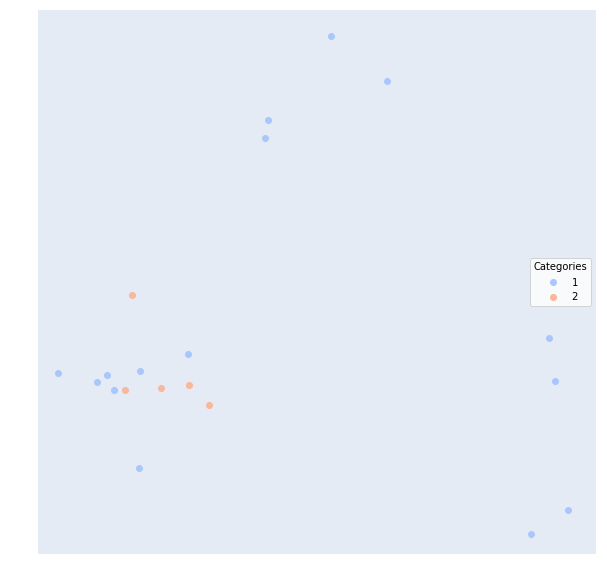

In [361]:
model = bag
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

In [367]:
rdf = sklearn.ensemble.RandomForestClassifier()
rdf.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Test Accuracy:
0.8

Recall Score:
0.8

F1 Score:
0.8549019607843137


          AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                       
1         0.6           0.789474         0.2   0.789474     1.0
2         0.6           0.400000         0.2   1.000000     0.2


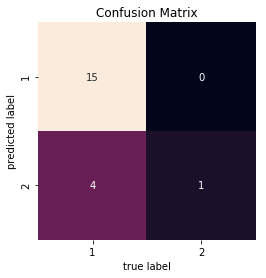

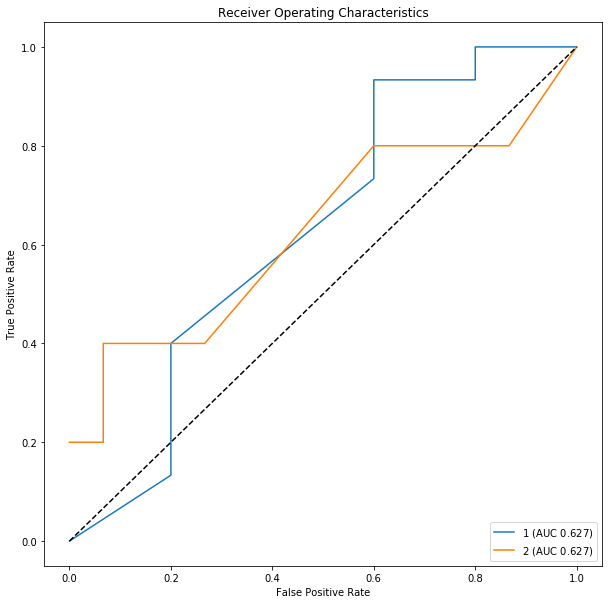

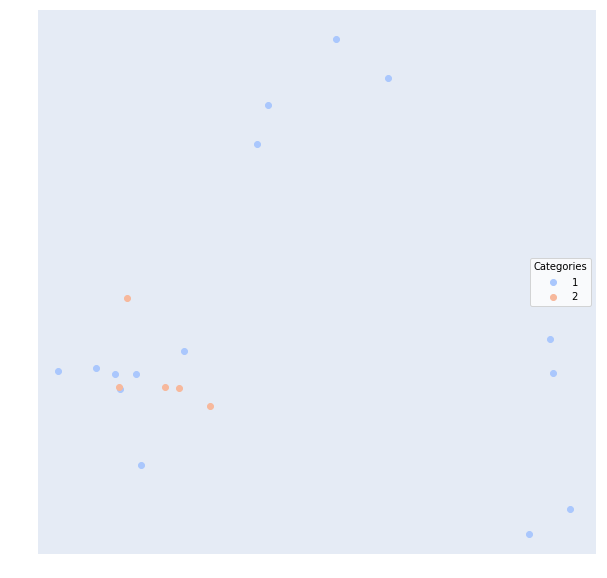

In [368]:
model = rdf
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

In [362]:
n_neighbors = 10
weights="distance"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')


Test Accuracy:
0.85

Recall Score:
0.85

F1 Score:
0.8753246753246753


          AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                       
1         0.7           0.833333        0.15   0.833333     1.0
2         0.7           0.550000        0.15   1.000000     0.4


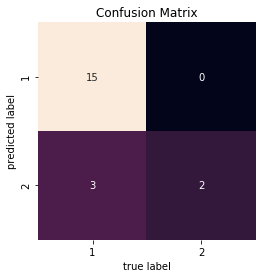

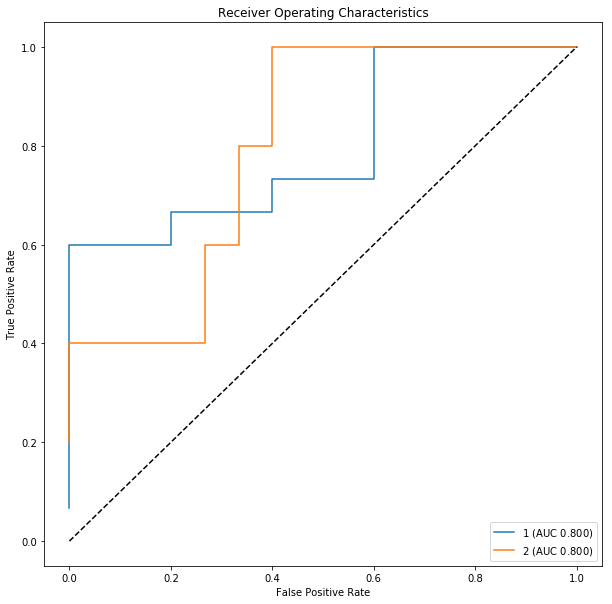

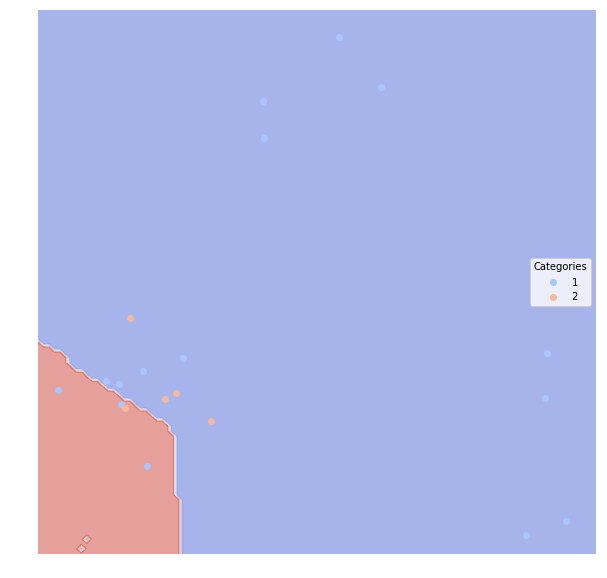

In [363]:
model = clf_knearest
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

In [365]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Test Accuracy:
0.7

Recall Score:
0.7

F1 Score:
0.7000000000000001


          AUC  Average_Precision  Error_Rate  Precision  Recall
Category                                                       
1         0.6               0.79         0.3        0.8     0.8
2         0.6               0.31         0.3        0.4     0.4


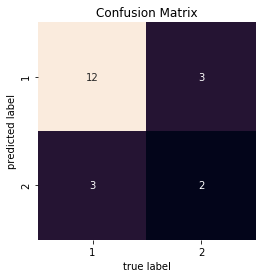

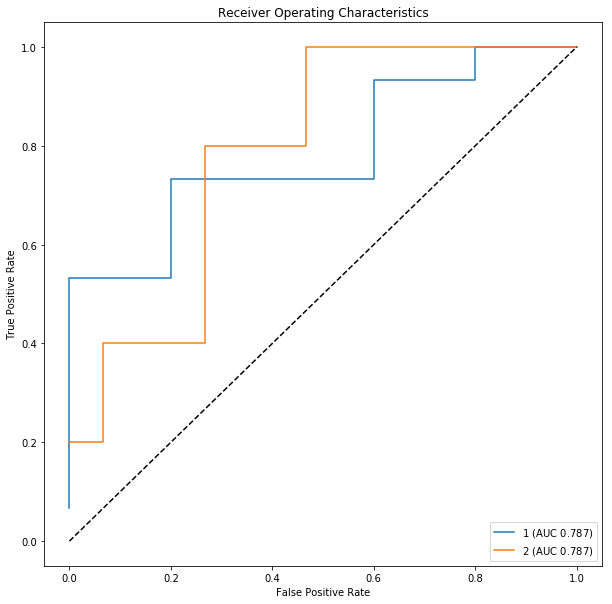

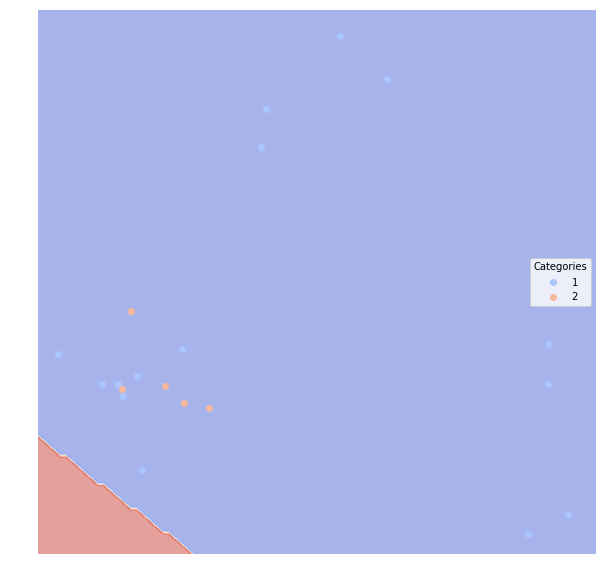

In [366]:
model = clf_nn
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

In [369]:
gb = sklearn.ensemble.GradientBoostingClassifier()
gb.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


Test Accuracy:
0.8

Recall Score:
0.8

F1 Score:
0.8


               AUC  Average_Precision  Error_Rate  Precision    Recall
Category                                                              
1         0.733333           0.851111         0.2   0.866667  0.866667
2         0.733333           0.460000         0.2   0.600000  0.600000


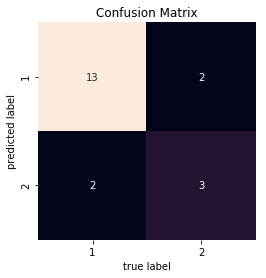

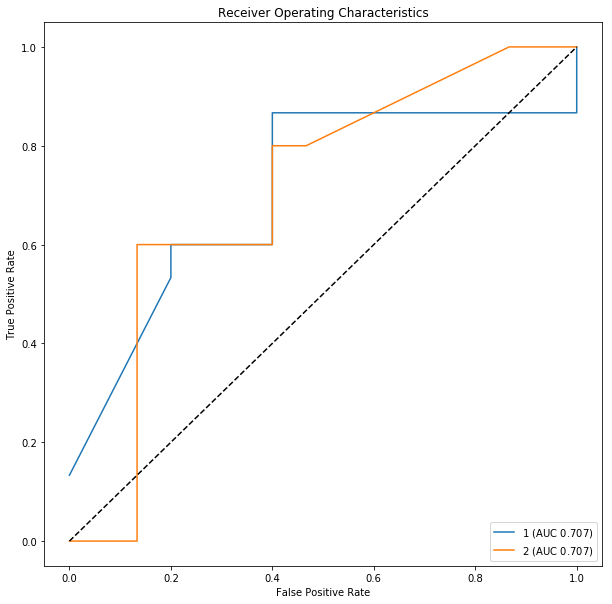

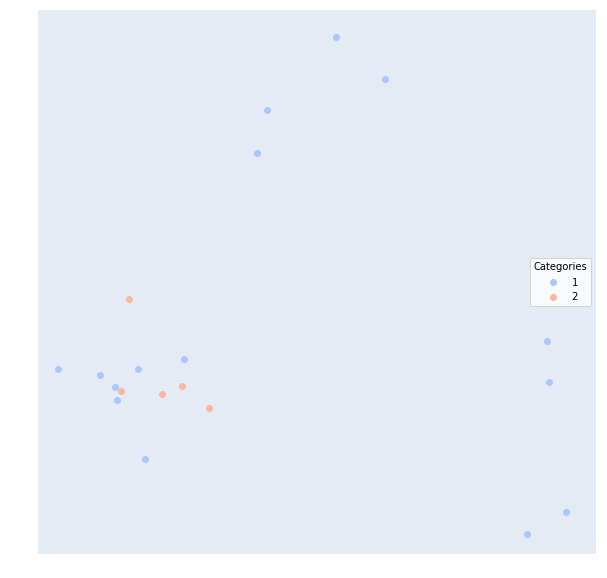

In [370]:
model = gb
print("\nTest Accuracy:")
print(sklearn.metrics.accuracy_score(test_data_df['category'],model.predict(np.stack(test_data_df['vect'], axis = 0))))
print("\nRecall Score:")
print(sklearn.metrics.recall_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #recall
print("\nF1 Score:")
print(sklearn.metrics.f1_score(model.predict(np.stack(test_data_df['vect'], axis = 0)), test_data_df['category'], average = 'weighted')) #F-1 measure
print("\n")

print(lucem_illud.metrics.evaluateClassifier(model, test_data_df))
lucem_illud.plotConfusionMatrix(model, test_data_df)
lucem_illud.plotMultiROC(model, test_data_df)
lucem_illud.plotregions(model, test_data_df)

## Memo: classification using 2 categories

As expected, the results of classification using the 2 simplified categories were much better.

The classfiers tested above using 2 categories include naive bayes, decision tree, bagging, random forest, KNN, neural nets, and gradient bossting. Among all these classifiers, KNN again had the best test accuracy (0.85), correctly predicting classes of 17 observations out of 20 test observations. Gradient boosting also had decent accuracy (0.8), corrently predicting 16 observations out of 20. 

A somewhat surprising result is that bagging had lower accuracy compared to simple decision tree in this case, considering that bagging usually provides some improvement over simple decision tree by removing randomness.

Moreover, a possible problem with classification using this corpus is that, the classes listed are not neccessarily exclusive. For example, a document maybe closely associated with both class 1 and class 2. Therefore, compared to classification, topic modeling seems to make more sense in this case.

Alternatively, if I want to further enhance the accuracy of classification in my final project, I should consider (1) to manually label more documents to provide a much larger training data set to work with; and (2) to hire more people to classify the documents to increase the consistency of the hand labeling process and to increase the chance of getting 'true class' for each manually labeled document.